In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Number of crack images: 11298
Number of mask images: 11298
Epoch 1/2
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 312s 189ms/step - accuracy: 0.9525 - loss: 0.1283
Epoch 2/2
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 267s 189ms/step - accuracy: 0.9582 - loss: 0.0661
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


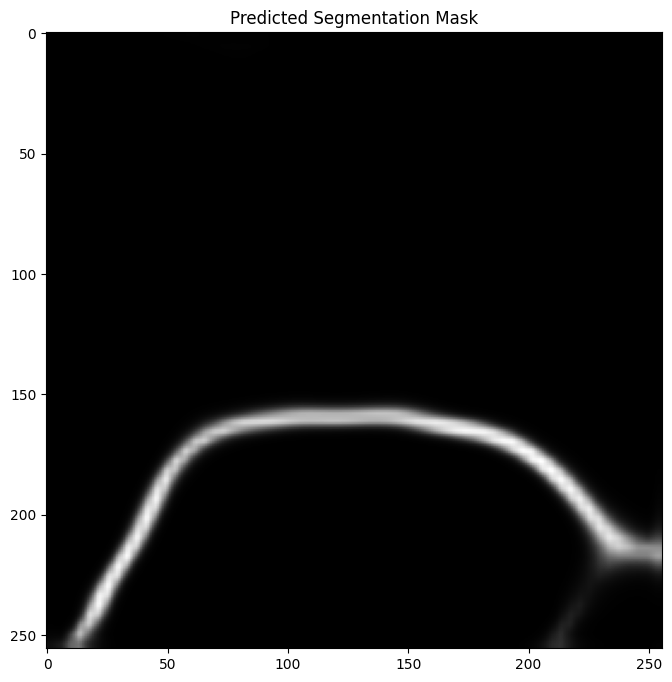

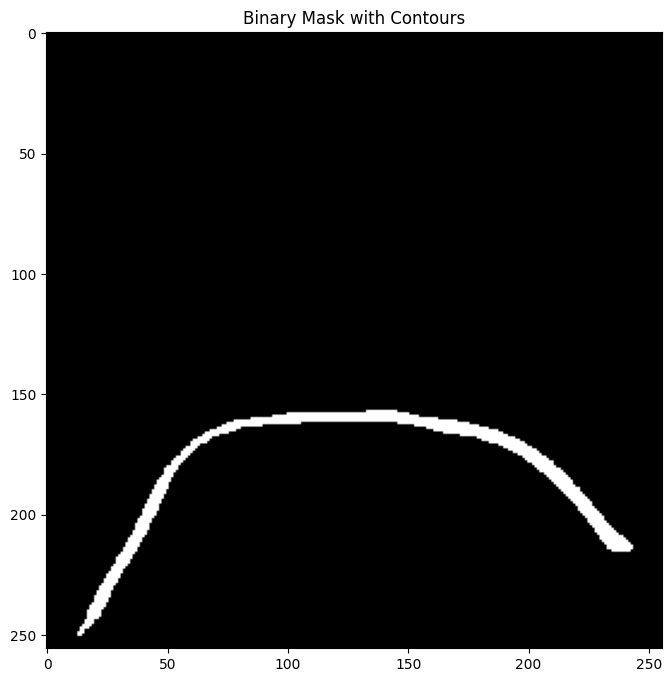

Bounding Box - X: 13, Y: 157, Width: 231, Height: 94


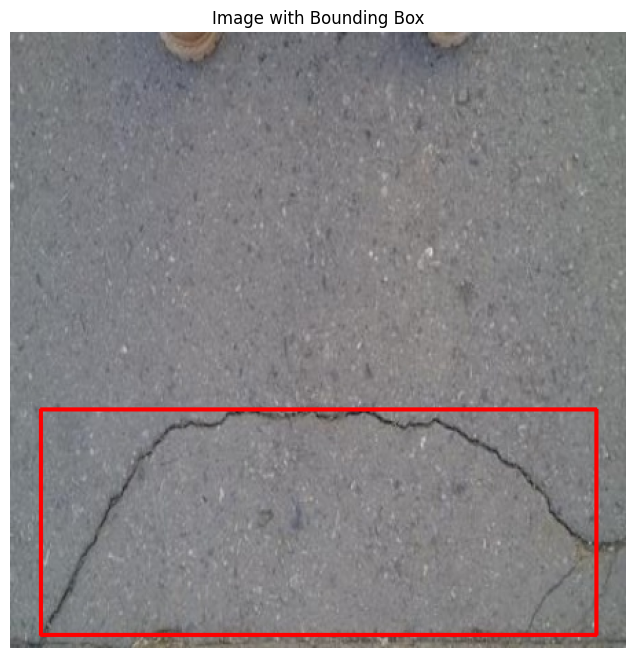

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.utils import Sequence

# Define paths to main crack and mask folders
CRACK_DIR = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/images"  # Replace with your cracks folder path
MASK_DIR = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/masks"   # Replace with your masks folder path

# List all images in cracks and masks directories
crack_image_paths = [os.path.join(CRACK_DIR, fname) for fname in os.listdir(CRACK_DIR) if fname.endswith(('.png', '.jpg'))]
mask_image_paths = [os.path.join(MASK_DIR, fname) for fname in os.listdir(MASK_DIR) if fname.endswith(('.png', '.jpg'))]

# Ensure the number of crack and mask images match
assert len(crack_image_paths) == len(mask_image_paths), "Mismatch between cracks and masks!"

print(f"Number of crack images: {len(crack_image_paths)}")
print(f"Number of mask images: {len(mask_image_paths)}")

# Load DeeplabV3 model with adjusted output
def load_deeplabv3(input_shape=(256, 256, 3)):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    x = base_model.output
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)  # Upsample to match mask size
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)  # Output shape matches masks
    model = Model(inputs=base_model.input, outputs=x)
    return model

deeplab_model = load_deeplabv3()

# Dataset generator for training
class CrackDataset(Sequence):
    def __init__(self, image_paths, mask_paths, target_size=(256, 256), batch_size=8):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.target_size = target_size
        self.batch_size = batch_size

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_images = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_masks = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        masks = []

        for img_path, mask_path in zip(batch_images, batch_masks):
            # Load and resize image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.target_size)
            img = img / 255.0  # Scale to [0, 1]

            # Load and resize mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.target_size)
            mask = mask / 255.0
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

# Create dataset
batch_size = 8
train_dataset = CrackDataset(crack_image_paths, mask_image_paths, batch_size=batch_size)

# Compile the model
deeplab_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
deeplab_model.fit(train_dataset, epochs=2)

def get_bounding_box(mask):
    """
    Extract the bounding box of the largest contour in the mask.
    """
    # Convert mask to binary (apply a threshold)
    binary_mask = (mask > 0.5).astype(np.uint8)
    
    # Apply morphological operations to improve mask quality
    kernel = np.ones((5, 5), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Debug: Display the binary mask with contours
    plt.figure(figsize=(8, 8))
    plt.title("Binary Mask with Contours")
    plt.imshow(binary_mask, cmap="gray")
    plt.show()

    # Find the largest contour
    if contours:
        max_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(max_contour)

        # Ensure the contour area is significant (to avoid noise)
        if cv2.contourArea(max_contour) > 100:  # Adjust threshold as needed
            return x, y, w, h
    return None

def predict_and_draw(image_path):
    """
    Predict the segmentation mask and draw a bounding box around the crack.
    """
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (256, 256))
    input_tensor = np.expand_dims(resized_image / 255.0, axis=0)

    # Predict the segmentation mask
    pred_mask = deeplab_model.predict(input_tensor)[0, :, :, 0]

    # Debug: Display the predicted segmentation mask
    plt.figure(figsize=(8, 8))
    plt.title("Predicted Segmentation Mask")
    plt.imshow(pred_mask, cmap="gray")
    plt.show()

    # Get bounding box from the segmentation mask
    bbox = get_bounding_box(pred_mask)
    if bbox:
        x, y, w, h = bbox
        print(f"Bounding Box - X: {x}, Y: {y}, Width: {w}, Height: {h}")

        # Rescale bounding box to the original image dimensions
        scale_x = image.shape[1] / 256
        scale_y = image.shape[0] / 256
        x = int(x * scale_x)
        y = int(y * scale_y)
        w = int(w * scale_x)
        h = int(h * scale_y)

        # Draw the bounding box on the original image
        image_with_box = cv2.rectangle(image.copy(), (x, y), (x + w, y + h), (255, 0, 0), 2)
        plt.figure(figsize=(8, 8))
        plt.title("Image with Bounding Box")
        plt.imshow(image_with_box)
        plt.axis("off")
        plt.show()
    else:
        print("No significant crack detected.")

# Test the updated function with an example image
example_image_path = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/images/CFD_004.jpg"  # Replace with your image path
predict_and_draw(example_image_path)


Number of crack images: 11298
Number of mask images: 11298
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/2


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732434279.761973      95 service.cc:145] XLA service 0x7ff1f8003bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732434279.762023      95 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732434279.762027      95 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732434309.409329      95 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1732434309.451

1412/1412 ━━━━━━━━━━━━━━━━━━━━ 326s 190ms/step - accuracy: 0.9484 - loss: 0.1395
Epoch 2/2
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 286s 202ms/step - accuracy: 0.9578 - loss: 0.0663
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


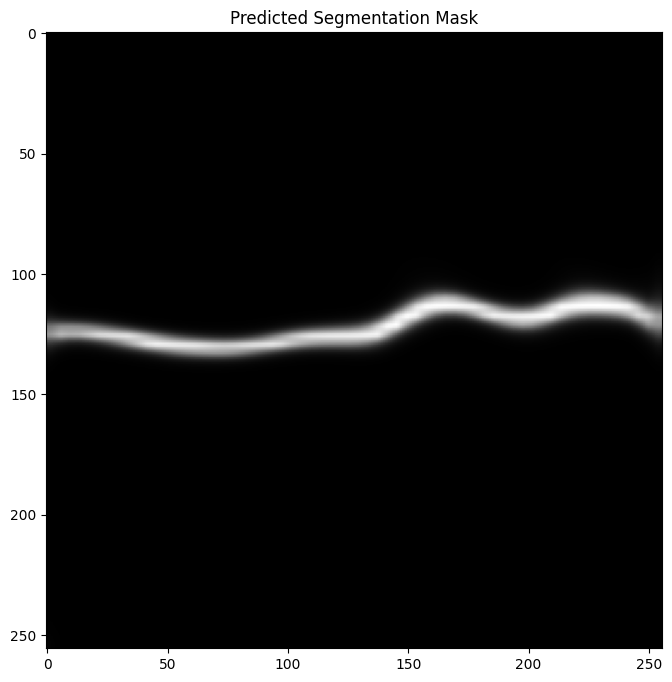

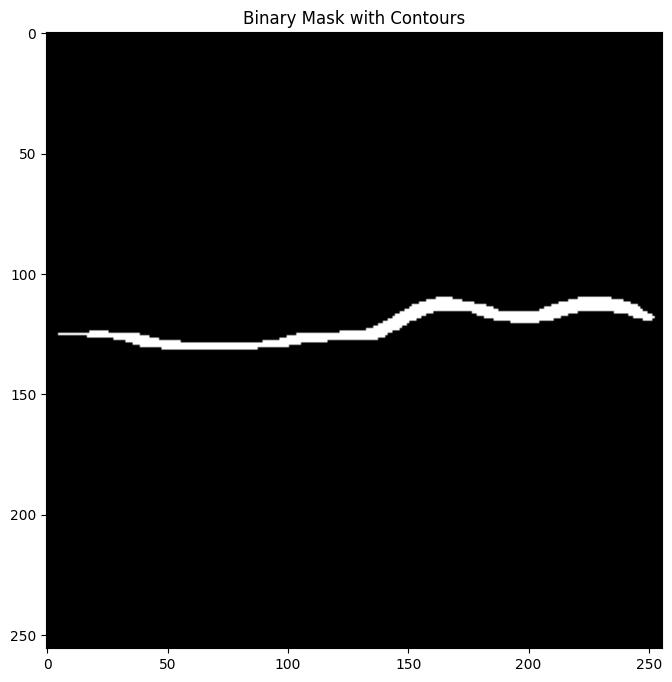

Bounding Box - X: 5, Y: 110, Width: 248, Height: 22


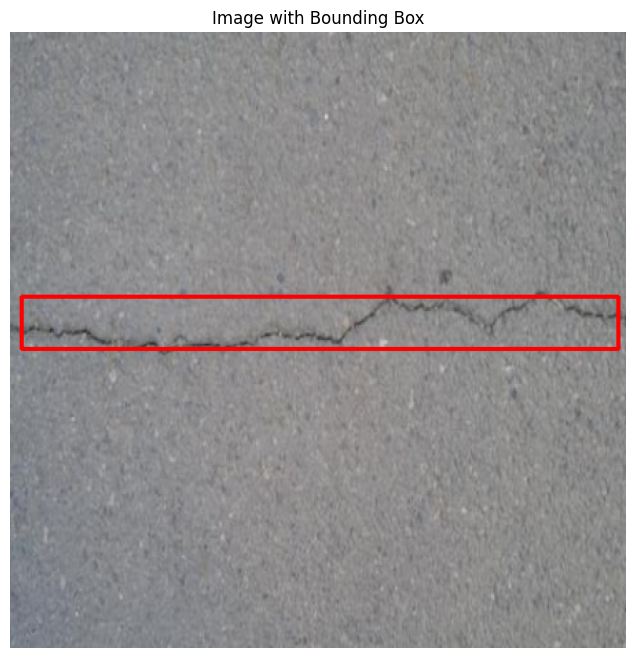

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.utils import Sequence

# Define paths to main crack and mask folders
CRACK_DIR = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/images"  # Replace with your cracks folder path
MASK_DIR = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/masks"   # Replace with your masks folder path

# List all images in cracks and masks directories
crack_image_paths = [os.path.join(CRACK_DIR, fname) for fname in os.listdir(CRACK_DIR) if fname.endswith(('.png', '.jpg'))]
mask_image_paths = [os.path.join(MASK_DIR, fname) for fname in os.listdir(MASK_DIR) if fname.endswith(('.png', '.jpg'))]

# Ensure the number of crack and mask images match
assert len(crack_image_paths) == len(mask_image_paths), "Mismatch between cracks and masks!"

print(f"Number of crack images: {len(crack_image_paths)}")
print(f"Number of mask images: {len(mask_image_paths)}")

# Load DeeplabV3 model with adjusted output
def load_deeplabv3(input_shape=(256, 256, 3)):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    x = base_model.output
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)  # Upsample to match mask size
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)  # Output shape matches masks
    model = Model(inputs=base_model.input, outputs=x)
    return model

deeplab_model = load_deeplabv3()

# Dataset generator for training
class CrackDataset(Sequence):
    def __init__(self, image_paths, mask_paths, target_size=(256, 256), batch_size=8):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.target_size = target_size
        self.batch_size = batch_size

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_images = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_masks = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        masks = []

        for img_path, mask_path in zip(batch_images, batch_masks):
            # Load and resize image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.target_size)
            img = img / 255.0  # Scale to [0, 1]

            # Load and resize mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.target_size)
            mask = mask / 255.0
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

# Create dataset
batch_size = 8
train_dataset = CrackDataset(crack_image_paths, mask_image_paths, batch_size=batch_size)

# Compile the model
deeplab_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
deeplab_model.fit(train_dataset, epochs=2)

def get_bounding_box(mask):
    """
    Extract the bounding box of the largest contour in the mask.
    """
    # Convert mask to binary (apply a threshold)
    binary_mask = (mask > 0.5).astype(np.uint8)
    
    # Apply morphological operations to improve mask quality
    kernel = np.ones((5, 5), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Debug: Display the binary mask with contours
    plt.figure(figsize=(8, 8))
    plt.title("Binary Mask with Contours")
    plt.imshow(binary_mask, cmap="gray")
    plt.show()

    # Find the largest contour
    if contours:
        max_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(max_contour)

        # Ensure the contour area is significant (to avoid noise)
        if cv2.contourArea(max_contour) > 100:  # Adjust threshold as needed
            return x, y, w, h
    return None

def predict_and_draw(image_path):
    """
    Predict the segmentation mask and draw a bounding box around the crack.
    """
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (256, 256))
    input_tensor = np.expand_dims(resized_image / 255.0, axis=0)

    # Predict the segmentation mask
    pred_mask = deeplab_model.predict(input_tensor)[0, :, :, 0]

    # Debug: Display the predicted segmentation mask
    plt.figure(figsize=(8, 8))
    plt.title("Predicted Segmentation Mask")
    plt.imshow(pred_mask, cmap="gray")
    plt.show()

    # Get bounding box from the segmentation mask
    bbox = get_bounding_box(pred_mask)
    if bbox:
        x, y, w, h = bbox
        print(f"Bounding Box - X: {x}, Y: {y}, Width: {w}, Height: {h}")

        # Rescale bounding box to the original image dimensions
        scale_x = image.shape[1] / 256
        scale_y = image.shape[0] / 256
        x = int(x * scale_x)
        y = int(y * scale_y)
        w = int(w * scale_x)
        h = int(h * scale_y)

        # Draw the bounding box on the original image
        image_with_box = cv2.rectangle(image.copy(), (x, y), (x + w, y + h), (255, 0, 0), 2)
        plt.figure(figsize=(8, 8))
        plt.title("Image with Bounding Box")
        plt.imshow(image_with_box)
        plt.axis("off")
        plt.show()
    else:
        print("No significant crack detected.")

# Test the updated function with an example image
example_image_path = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/images/CFD_010.jpg"  # Replace with your image path
predict_and_draw(example_image_path)


Number of crack images: 11298
Number of mask images: 11298
Epoch 1/2
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 321s 197ms/step - accuracy: 0.9485 - loss: 0.1200
Epoch 2/2
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 287s 203ms/step - accuracy: 0.9585 - loss: 0.0647
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


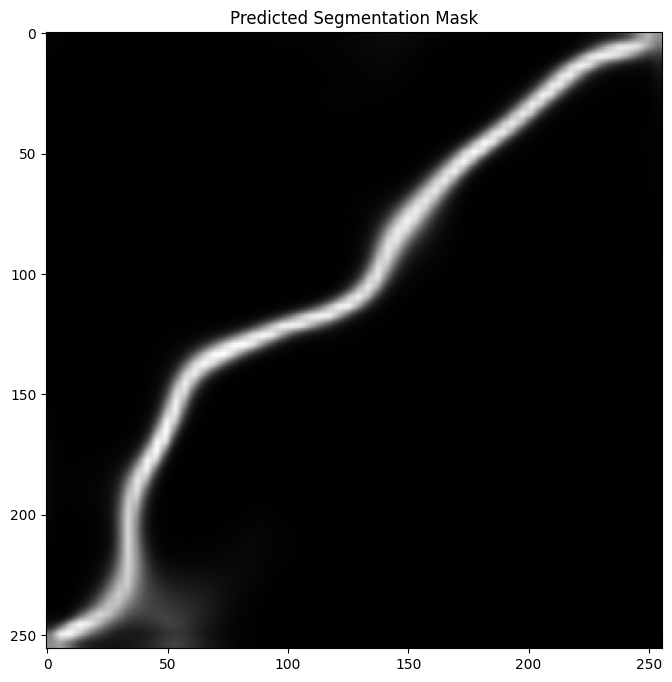

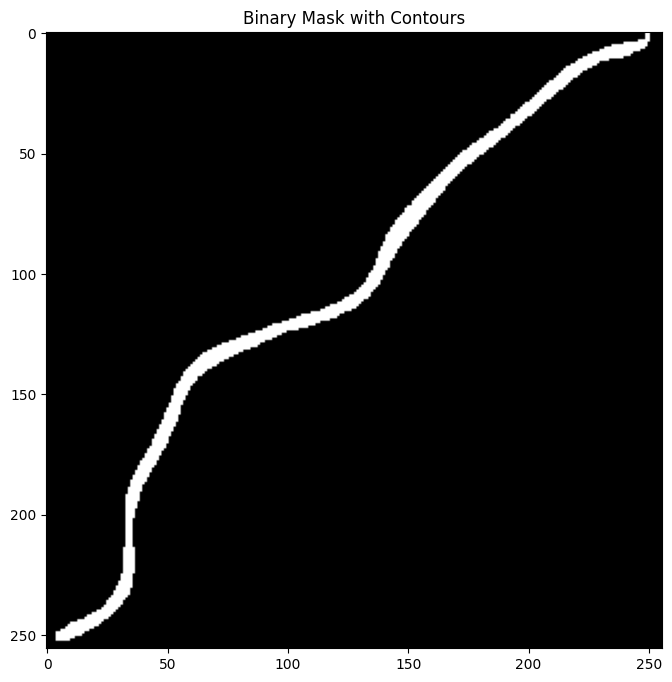

Bounding Box - X: 4, Y: 0, Width: 247, Height: 253


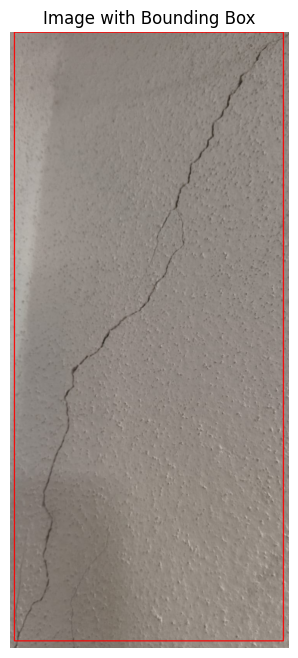

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.utils import Sequence

# Define paths to main crack and mask folders
CRACK_DIR = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/images"  # Replace with your cracks folder path
MASK_DIR = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/masks"   # Replace with your masks folder path

# List all images in cracks and masks directories
crack_image_paths = [os.path.join(CRACK_DIR, fname) for fname in os.listdir(CRACK_DIR) if fname.endswith(('.png', '.jpg'))]
mask_image_paths = [os.path.join(MASK_DIR, fname) for fname in os.listdir(MASK_DIR) if fname.endswith(('.png', '.jpg'))]

# Ensure the number of crack and mask images match
assert len(crack_image_paths) == len(mask_image_paths), "Mismatch between cracks and masks!"

print(f"Number of crack images: {len(crack_image_paths)}")
print(f"Number of mask images: {len(mask_image_paths)}")

# Load DeeplabV3 model with adjusted output
def load_deeplabv3(input_shape=(256, 256, 3)):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    x = base_model.output
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)  # Upsample to match mask size
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)  # Output shape matches masks
    model = Model(inputs=base_model.input, outputs=x)
    return model

deeplab_model = load_deeplabv3()

# Dataset generator for training
class CrackDataset(Sequence):
    def __init__(self, image_paths, mask_paths, target_size=(256, 256), batch_size=8):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.target_size = target_size
        self.batch_size = batch_size

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_images = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_masks = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        masks = []

        for img_path, mask_path in zip(batch_images, batch_masks):
            # Load and resize image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.target_size)
            img = img / 255.0  # Scale to [0, 1]

            # Load and resize mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.target_size)
            mask = mask / 255.0
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

# Create dataset
batch_size = 8
train_dataset = CrackDataset(crack_image_paths, mask_image_paths, batch_size=batch_size)

# Compile the model
deeplab_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
deeplab_model.fit(train_dataset, epochs=2)

def get_bounding_box(mask):
    """
    Extract the bounding box of the largest contour in the mask.
    """
    # Convert mask to binary (apply a threshold)
    binary_mask = (mask > 0.5).astype(np.uint8)
    
    # Apply morphological operations to improve mask quality
    kernel = np.ones((5, 5), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Debug: Display the binary mask with contours
    plt.figure(figsize=(8, 8))
    plt.title("Binary Mask with Contours")
    plt.imshow(binary_mask, cmap="gray")
    plt.show()

    # Find the largest contour
    if contours:
        max_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(max_contour)

        # Ensure the contour area is significant (to avoid noise)
        if cv2.contourArea(max_contour) > 100:  # Adjust threshold as needed
            return x, y, w, h
    return None

def predict_and_draw(image_path):
    """
    Predict the segmentation mask and draw a bounding box around the crack.
    """
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (256, 256))
    input_tensor = np.expand_dims(resized_image / 255.0, axis=0)

    # Predict the segmentation mask
    pred_mask = deeplab_model.predict(input_tensor)[0, :, :, 0]

    # Debug: Display the predicted segmentation mask
    plt.figure(figsize=(8, 8))
    plt.title("Predicted Segmentation Mask")
    plt.imshow(pred_mask, cmap="gray")
    plt.show()

    # Get bounding box from the segmentation mask
    bbox = get_bounding_box(pred_mask)
    if bbox:
        x, y, w, h = bbox
        print(f"Bounding Box - X: {x}, Y: {y}, Width: {w}, Height: {h}")

        # Rescale bounding box to the original image dimensions
        scale_x = image.shape[1] / 256
        scale_y = image.shape[0] / 256
        x = int(x * scale_x)
        y = int(y * scale_y)
        w = int(w * scale_x)
        h = int(h * scale_y)

        # Draw the bounding box on the original image
        image_with_box = cv2.rectangle(image.copy(), (x, y), (x + w, y + h), (255, 0, 0), 2)
        plt.figure(figsize=(8, 8))
        plt.title("Image with Bounding Box")
        plt.imshow(image_with_box)
        plt.axis("off")
        plt.show()
    else:
        print("No significant crack detected.")

# Test the updated function with an example image
example_image_path = "/kaggle/input/homecrack1/WhatsApp Image 2024-11-24 at 1.32.56 PM (1).jpeg"  # Replace with your image path
predict_and_draw(example_image_path)


Number of crack images: 11298
Number of mask images: 11298
Epoch 1/5
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 332s 203ms/step - accuracy: 0.9528 - loss: 0.1239
Epoch 2/5
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 286s 202ms/step - accuracy: 0.9582 - loss: 0.0649
Epoch 3/5
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 286s 202ms/step - accuracy: 0.9592 - loss: 0.0626
Epoch 4/5
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 285s 202ms/step - accuracy: 0.9600 - loss: 0.0592
Epoch 5/5
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 284s 201ms/step - accuracy: 0.9566 - loss: 0.0829
Model saved to /kaggle/working/deeplab_model.h5
Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


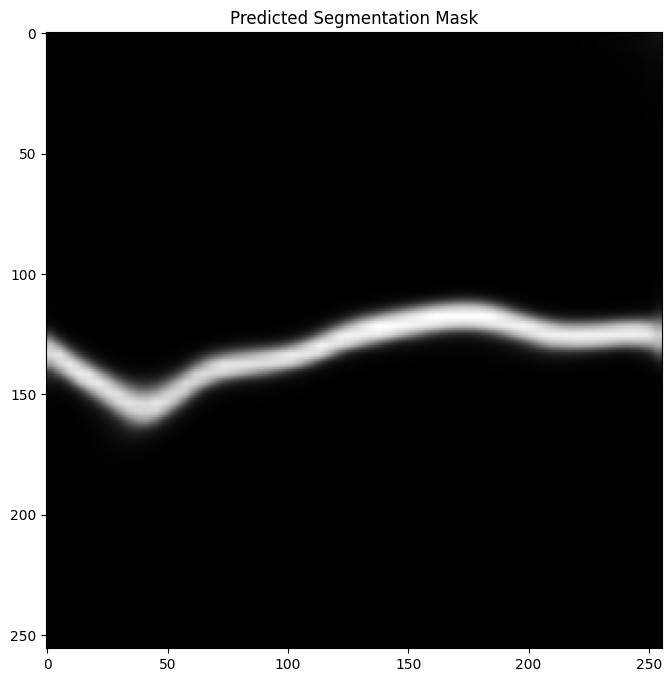

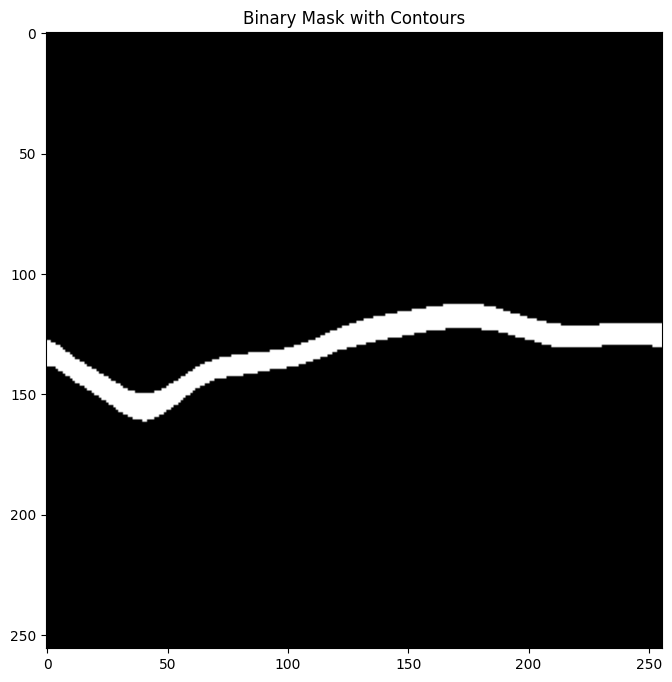

Bounding Box - X: 0, Y: 113, Width: 256, Height: 49


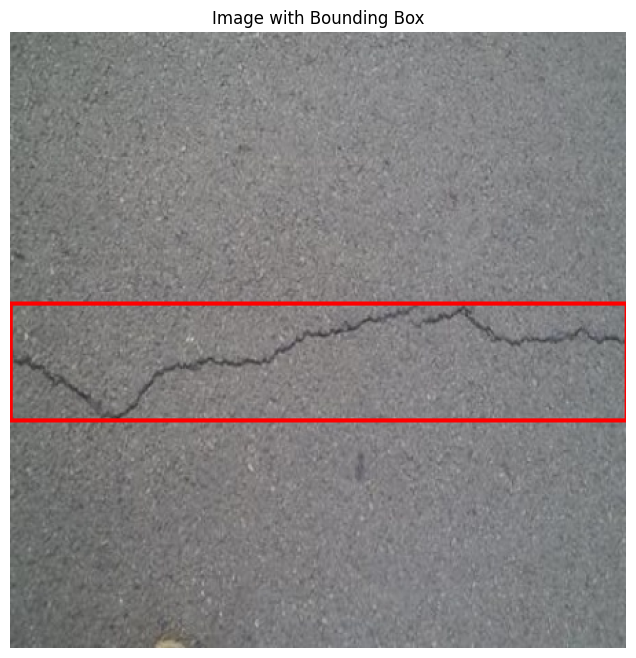

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.utils import Sequence

# Define paths to main crack and mask folders
CRACK_DIR = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/images"  # Replace with your cracks folder path
MASK_DIR = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/masks"   # Replace with your masks folder path

# List all images in cracks and masks directories
crack_image_paths = [os.path.join(CRACK_DIR, fname) for fname in os.listdir(CRACK_DIR) if fname.endswith(('.png', '.jpg'))]
mask_image_paths = [os.path.join(MASK_DIR, fname) for fname in os.listdir(MASK_DIR) if fname.endswith(('.png', '.jpg'))]

# Ensure the number of crack and mask images match
assert len(crack_image_paths) == len(mask_image_paths), "Mismatch between cracks and masks!"

print(f"Number of crack images: {len(crack_image_paths)}")
print(f"Number of mask images: {len(mask_image_paths)}")

# Load DeeplabV3 model with adjusted output
def load_deeplabv3(input_shape=(256, 256, 3)):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    x = base_model.output
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)  # Upsample to match mask size
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)  # Output shape matches masks
    model = Model(inputs=base_model.input, outputs=x)
    return model

deeplab_model = load_deeplabv3()

# Dataset generator for training
class CrackDataset(Sequence):
    def __init__(self, image_paths, mask_paths, target_size=(256, 256), batch_size=8):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.target_size = target_size
        self.batch_size = batch_size

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_images = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_masks = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        masks = []

        for img_path, mask_path in zip(batch_images, batch_masks):
            # Load and resize image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.target_size)
            img = img / 255.0  # Scale to [0, 1]

            # Load and resize mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.target_size)
            mask = mask / 255.0
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

# Create dataset
batch_size = 8
train_dataset = CrackDataset(crack_image_paths, mask_image_paths, batch_size=batch_size)

# Compile the model
deeplab_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
deeplab_model.fit(train_dataset, epochs=5)

# Save the trained model
MODEL_PATH = "/kaggle/working/deeplab_model.h5"
deeplab_model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

# Load the trained model (if needed later)
loaded_model = tf.keras.models.load_model(MODEL_PATH, custom_objects={'UpSampling2D': UpSampling2D})
print("Model loaded successfully!")

# Prediction function
def predict_and_draw(image_path):
    """
    Predict the segmentation mask and draw a bounding box around the crack.
    """
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (256, 256))
    input_tensor = np.expand_dims(resized_image / 255.0, axis=0)

    # Predict the segmentation mask
    pred_mask = loaded_model.predict(input_tensor)[0, :, :, 0]

    # Debug: Display the predicted segmentation mask
    plt.figure(figsize=(8, 8))
    plt.title("Predicted Segmentation Mask")
    plt.imshow(pred_mask, cmap="gray")
    plt.show()

    # Get bounding box from the segmentation mask
    bbox = get_bounding_box(pred_mask)
    if bbox:
        x, y, w, h = bbox
        print(f"Bounding Box - X: {x}, Y: {y}, Width: {w}, Height: {h}")

        # Rescale bounding box to the original image dimensions
        scale_x = image.shape[1] / 256
        scale_y = image.shape[0] / 256
        x = int(x * scale_x)
        y = int(y * scale_y)
        w = int(w * scale_x)
        h = int(h * scale_y)

        # Draw the bounding box on the original image
        image_with_box = cv2.rectangle(image.copy(), (x, y), (x + w, y + h), (255, 0, 0), 2)
        plt.figure(figsize=(8, 8))
        plt.title("Image with Bounding Box")
        plt.imshow(image_with_box)
        plt.axis("off")
        plt.show()
    else:
        print("No significant crack detected.")

# Test the updated function with an example image
example_image_path = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/images/CFD_001.jpg"  # Replace with your image path
predict_and_draw(example_image_path)


Number of crack images: 11298
Number of mask images: 11298
Epoch 1/2
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 324s 198ms/step - accuracy: 0.9516 - loss: 0.1348
Epoch 2/2
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 280s 198ms/step - accuracy: 0.9582 - loss: 0.0653
Model saved to /kaggle/working/deeplab_model.h5
Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


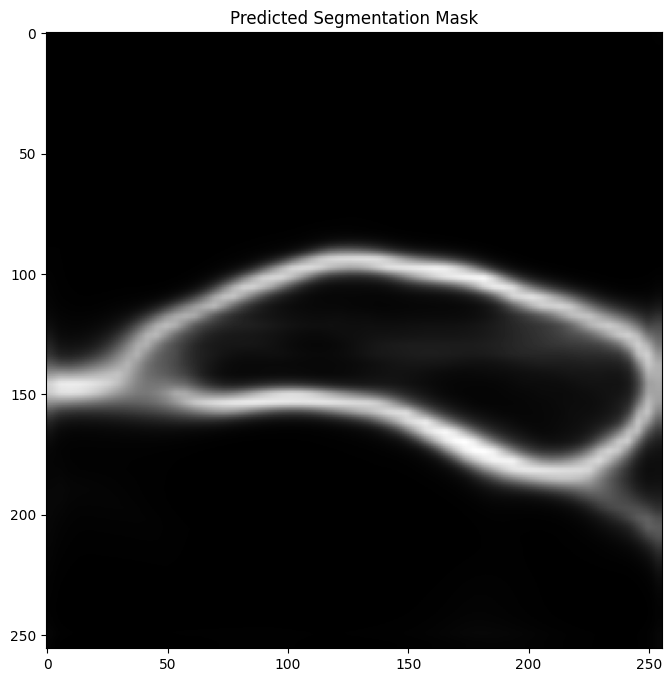

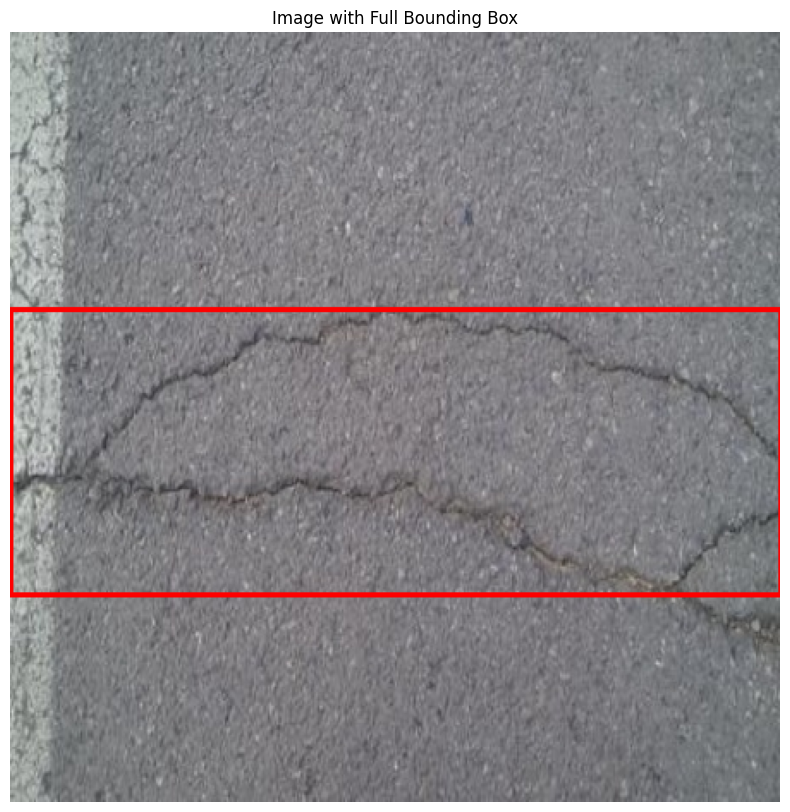

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.utils import Sequence

# Define paths to main crack and mask folders
CRACK_DIR = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/images"  # Replace with your cracks folder path
MASK_DIR = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/masks"   # Replace with your masks folder path

# List all images in cracks and masks directories
crack_image_paths = [os.path.join(CRACK_DIR, fname) for fname in os.listdir(CRACK_DIR) if fname.endswith(('.png', '.jpg'))]
mask_image_paths = [os.path.join(MASK_DIR, fname) for fname in os.listdir(MASK_DIR) if fname.endswith(('.png', '.jpg'))]

# Ensure the number of crack and mask images match
assert len(crack_image_paths) == len(mask_image_paths), "Mismatch between cracks and masks!"

print(f"Number of crack images: {len(crack_image_paths)}")
print(f"Number of mask images: {len(mask_image_paths)}")

# Load DeeplabV3-like model with adjusted output
def load_deeplabv3(input_shape=(256, 256, 3)):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    x = base_model.output
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)  # Upsample to match mask size
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)  # Output shape matches masks
    model = Model(inputs=base_model.input, outputs=x)
    return model

deeplab_model = load_deeplabv3()

# Dataset generator for training
class CrackDataset(Sequence):
    def __init__(self, image_paths, mask_paths, target_size=(256, 256), batch_size=8):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.target_size = target_size
        self.batch_size = batch_size

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_images = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_masks = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        masks = []

        for img_path, mask_path in zip(batch_images, batch_masks):
            # Load and resize image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.target_size)
            img = img / 255.0  # Scale to [0, 1]

            # Load and resize mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.target_size)
            mask = mask / 255.0
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

# Create dataset
batch_size = 8
train_dataset = CrackDataset(crack_image_paths, mask_image_paths, batch_size=batch_size)

# Compile the model
deeplab_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
deeplab_model.fit(train_dataset, epochs=2)

# Save the trained model
MODEL_PATH = "/kaggle/working/deeplab_model.h5"
deeplab_model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

# Load the trained model (if needed later)
loaded_model = tf.keras.models.load_model(MODEL_PATH, custom_objects={'UpSampling2D': UpSampling2D})
print("Model loaded successfully!")

def get_single_bounding_box(mask):
    """
    Extract a single bounding box that encapsulates the entire crack in the mask.
    """
    # Convert mask to binary with a threshold
    binary_mask = (mask > 0.5).astype(np.uint8)

    # Apply morphological operations to close gaps
    kernel = np.ones((5, 5), np.uint8)
    cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # Find contours from the cleaned mask
    contours, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None  # No crack detected

    # Combine all contours into a single bounding box
    x_min, y_min, x_max, y_max = float('inf'), float('inf'), 0, 0
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + w)
        y_max = max(y_max, y + h)

    return (x_min, y_min, x_max - x_min, y_max - y_min)

# Updated prediction and drawing function
def predict_and_draw_full_bbox(image_path):
    """
    Predict segmentation mask, clean it, and draw a single bounding box around the full crack.
    """
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (256, 256))
    input_tensor = np.expand_dims(resized_image / 255.0, axis=0)

    # Predict the segmentation mask
    pred_mask = loaded_model.predict(input_tensor)[0, :, :, 0]

    # Debug: Display the predicted segmentation mask
    plt.figure(figsize=(8, 8))
    plt.title("Predicted Segmentation Mask")
    plt.imshow(pred_mask, cmap="gray")
    plt.show()

    # Get the full bounding box from the mask
    full_bbox = get_single_bounding_box(pred_mask)

    # Draw the full bounding box on the original image
    if full_bbox:
        scale_x = image.shape[1] / 256
        scale_y = image.shape[0] / 256

        x, y, w, h = full_bbox

        # Scale bounding box back to the original image dimensions
        x = int(x * scale_x)
        y = int(y * scale_y)
        w = int(w * scale_x)
        h = int(h * scale_y)

        # Draw the bounding box on the image
        image_with_box = image.copy()
        cv2.rectangle(image_with_box, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Display the image with the bounding box
        plt.figure(figsize=(10, 10))
        plt.title("Image with Full Bounding Box")
        plt.imshow(image_with_box)
        plt.axis("off")
        plt.show()
    else:
        print("No significant crack detected.")


# Test the updated function
example_image_path = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/images/CFD_013.jpg"  # Replace with your image path
predict_and_draw_full_bbox(example_image_path)

In [1]:
import numpy as np
import pandas as pd
from PIL import Image

# Load binary mask
binary_mask_path = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/masks/CFD_001.jpg"
mask = Image.open(binary_mask_path).convert("L")  # Convert to grayscale
mask = np.array(mask)
mask[mask > 0] = 1  # Ensure binary (0 and 1)

# Initialize an empty list to store crack widths
crack_widths = []

# Loop through each row of the mask to calculate widths
for row in mask:
    # Find positions where crack pixels (value 1) exist
    crack_positions = np.where(row == 1)[0]
    
    if len(crack_positions) > 1:
        # Calculate width as the difference between max and min positions
        width = crack_positions[-1] - crack_positions[0] + 1
        crack_widths.append(width)

# Summary statistics
if crack_widths:
    avg_width = np.mean(crack_widths)
    min_width = np.min(crack_widths)
    max_width = np.max(crack_widths)
    print(f"Average Crack Width: {avg_width:.2f} pixels")
    print(f"Minimum Crack Width: {min_width} pixels")
    print(f"Maximum Crack Width: {max_width} pixels")
else:
    print("No cracks detected in the binary mask!")

# Export binary mask to CSV
df = pd.DataFrame(mask)
csv_path = "binary_mask.csv"
df.to_csv(csv_path, index=False, header=False)
print(f"Binary mask exported to {csv_path}")

# Export crack widths to CSV
width_data = pd.DataFrame({
    "Width": crack_widths
})
width_csv_path = "crack_widths.csv"
width_data.to_csv(width_csv_path, index=False)
print(f"Crack width data exported to {width_csv_path}")


Average Crack Width: 142.31 pixels
Minimum Crack Width: 7 pixels
Maximum Crack Width: 448 pixels
Binary mask exported to binary_mask.csv
Crack width data exported to crack_widths.csv


Number of crack images: 11298
Number of mask images: 11298
Epoch 1/3


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732793537.107150      98 service.cc:145] XLA service 0x7c8f20005060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732793537.107209      98 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732793537.107213      98 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732793567.788452      98 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1732793567.831

1412/1412 ━━━━━━━━━━━━━━━━━━━━ 400s 240ms/step - accuracy: 0.9508 - loss: 0.1277
Epoch 2/3
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 266s 188ms/step - accuracy: 0.9586 - loss: 0.0643
Epoch 3/3
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 266s 188ms/step - accuracy: 0.9593 - loss: 0.0610
Model saved to /kaggle/working/deeplab_model.h5
Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


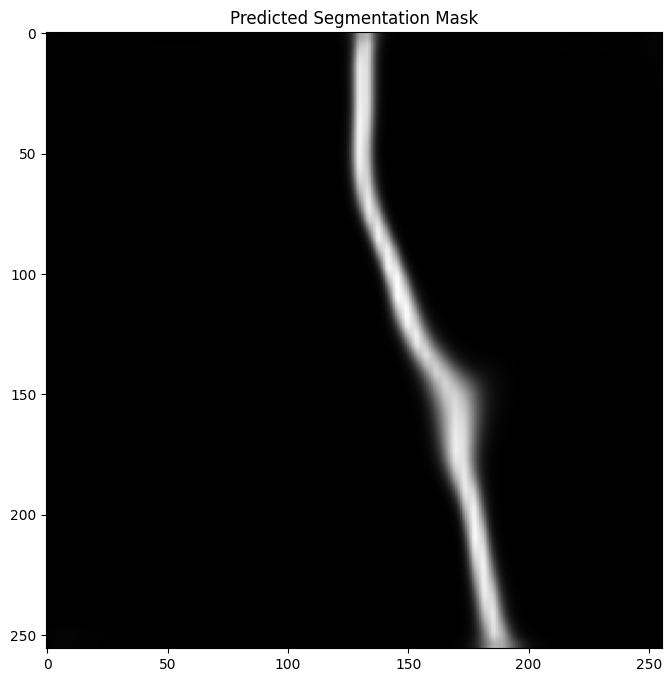

Bounding Box (pixels): x=128, y=0, width=63, height=256
Crack Width (pixels): Min=5, Max=12, Avg=7.48
Crack Width (mm): Min=0.50, Max=1.20, Avg=0.75
Crack Severity: Not Severe


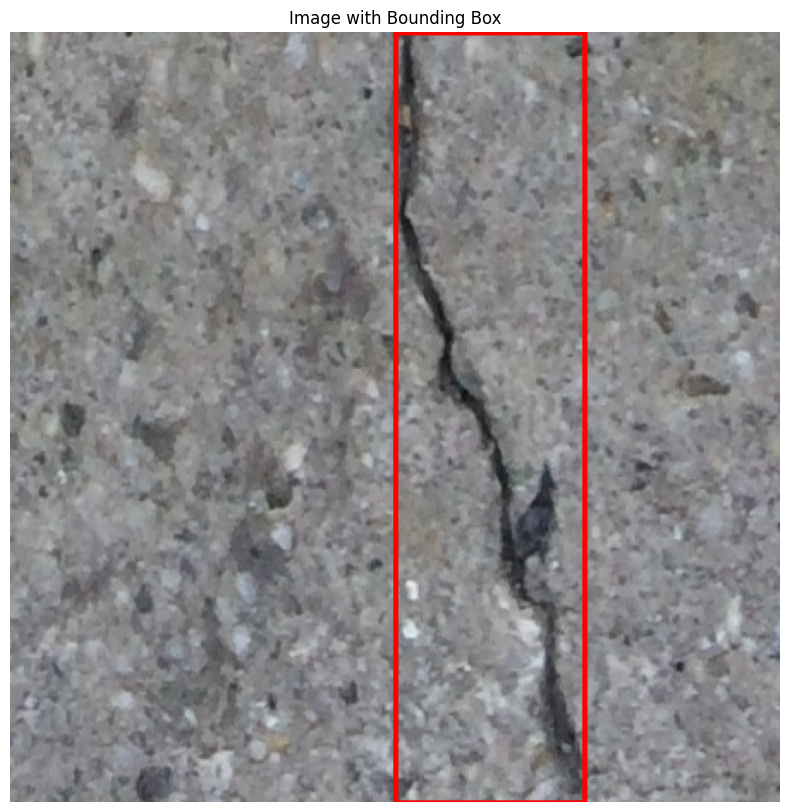

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.utils import Sequence

# Define paths to dataset
CRACK_DIR = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/images"  # Replace with your image path
MASK_DIR = "/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/masks"   # Replace with your mask path

# List all crack and mask images
crack_image_paths = [os.path.join(CRACK_DIR, fname) for fname in os.listdir(CRACK_DIR) if fname.endswith(('.png', '.jpg'))]
mask_image_paths = [os.path.join(MASK_DIR, fname) for fname in os.listdir(MASK_DIR) if fname.endswith(('.png', '.jpg'))]

# Ensure the number of images and masks match
assert len(crack_image_paths) == len(mask_image_paths), "Mismatch between cracks and masks!"

print(f"Number of crack images: {len(crack_image_paths)}")
print(f"Number of mask images: {len(mask_image_paths)}")

# Load DeeplabV3-like model
def load_deeplabv3(input_shape=(256, 256, 3)):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    x = base_model.output
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)  # Upsample to match mask size
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)  # Output shape matches masks
    model = Model(inputs=base_model.input, outputs=x)
    return model

deeplab_model = load_deeplabv3()

# Dataset generator for training
class CrackDataset(Sequence):
    def __init__(self, image_paths, mask_paths, target_size=(256, 256), batch_size=8):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.target_size = target_size
        self.batch_size = batch_size

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_images = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_masks = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        masks = []

        for img_path, mask_path in zip(batch_images, batch_masks):
            # Load and resize image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.target_size)
            img = img / 255.0  # Normalize to [0, 1]

            # Load and resize mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.target_size)
            mask = mask / 255.0
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

# Create training dataset
batch_size = 8
train_dataset = CrackDataset(crack_image_paths, mask_image_paths, batch_size=batch_size)

# Compile the model
deeplab_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model for 3 epochs
deeplab_model.fit(train_dataset, epochs=3)

# Save the trained model
MODEL_PATH = "/kaggle/working/deeplab_model.h5"
deeplab_model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

# Reload the model for inference
loaded_model = tf.keras.models.load_model(MODEL_PATH, custom_objects={'UpSampling2D': UpSampling2D})
print("Model loaded successfully!")

# Crack analysis functions
PIXEL_TO_MM_RATIO = 0.1  # Assume 1 pixel = 0.1 mm
SEVERITY_THRESHOLD_MM = 5.0  # Threshold in mm for crack severity

def get_single_bounding_box(mask):
    binary_mask = (mask > 0.5).astype(np.uint8)
    kernel = np.ones((5, 5), np.uint8)
    cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None  # No crack detected

    x_min, y_min, x_max, y_max = float('inf'), float('inf'), 0, 0
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + w)
        y_max = max(y_max, y + h)

    return (x_min, y_min, x_max - x_min, y_max - y_min)

def calculate_crack_width(mask):
    binary_mask = (mask > 0.5).astype(np.uint8)
    widths = []
    for row in binary_mask:
        crack_pixels = np.where(row == 1)[0]
        if len(crack_pixels) > 0:
            width = crack_pixels[-1] - crack_pixels[0] + 1
            widths.append(width)
    if not widths:
        return None, None, None
    return np.min(widths), np.max(widths), np.mean(widths)

# Prediction and analysis function
def predict_and_process(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (256, 256))
    input_tensor = np.expand_dims(resized_image / 255.0, axis=0)

    pred_mask = loaded_model.predict(input_tensor)[0, :, :, 0]

    full_bbox = get_single_bounding_box(pred_mask)
    min_width, max_width, avg_width = calculate_crack_width(pred_mask)

    if min_width is not None:
        min_width_mm = min_width * PIXEL_TO_MM_RATIO
        max_width_mm = max_width * PIXEL_TO_MM_RATIO
        avg_width_mm = avg_width * PIXEL_TO_MM_RATIO
    else:
        min_width_mm = max_width_mm = avg_width_mm = None

    severity = "Severe" if avg_width_mm and avg_width_mm > SEVERITY_THRESHOLD_MM else "Not Severe"

    plt.figure(figsize=(8, 8))
    plt.title("Predicted Segmentation Mask")
    plt.imshow(pred_mask, cmap="gray")
    plt.show()

    if full_bbox:
        x, y, w, h = full_bbox
        print(f"Bounding Box (pixels): x={x}, y={y}, width={w}, height={h}")
    else:
        print("No significant crack detected.")

    if min_width is not None:
        print(f"Crack Width (pixels): Min={min_width}, Max={max_width}, Avg={avg_width:.2f}")
        print(f"Crack Width (mm): Min={min_width_mm:.2f}, Max={max_width_mm:.2f}, Avg={avg_width_mm:.2f}")
        print(f"Crack Severity: {severity}")
    else:
        print("No crack width detected.")

    if full_bbox:
        scale_x = image.shape[1] / 256
        scale_y = image.shape[0] / 256
        x, y, w, h = full_bbox
        x = int(x * scale_x)
        y = int(y * scale_y)
        w = int(w * scale_x)
        h = int(h * scale_y)

        image_with_box = image.copy()
        cv2.rectangle(image_with_box, (x, y), (x + w, y + h), (255, 0, 0), 2)
        plt.figure(figsize=(10, 10))
        plt.title("Image with Bounding Box")
        plt.imshow(image_with_box)
        plt.axis("off")
        plt.show()

# Test on an example image
example_image_path = crack_image_paths[0]  # Replace with your image path
predict_and_process(example_image_path)


Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


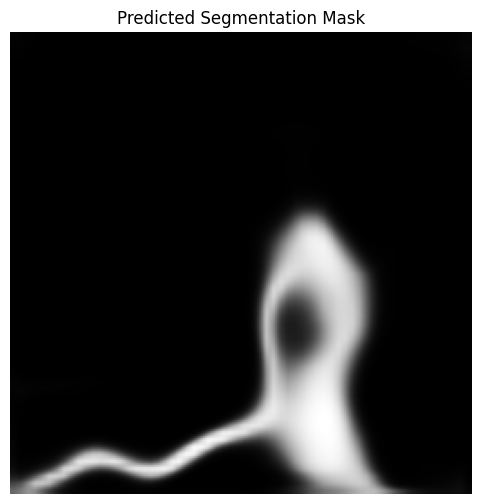

Bounding Box (pixels): x=8, y=104, width=200, height=152


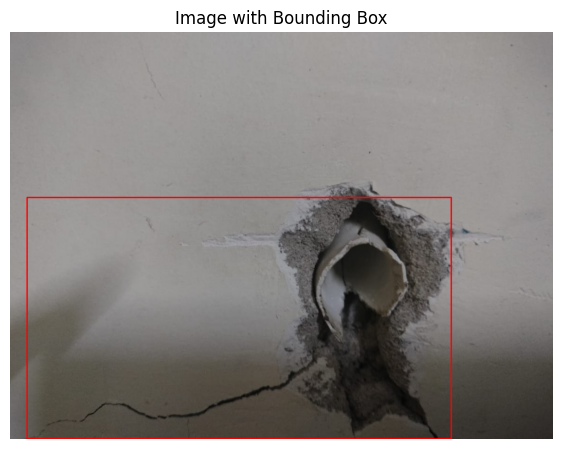

Crack Width (pixels): Min=8, Max=200, Avg=69.36
Crack Width (mm): Min=0.80, Max=20.00, Avg=6.94
Crack Severity: Severe


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Constants
PIXEL_TO_MM_RATIO = 0.1  # 1 pixel = 0.1 mm
SEVERITY_THRESHOLD_MM = 5.0  # Threshold in mm for severity

# Load the trained model
MODEL_PATH = "/kaggle/working/deeplab_model.h5"
loaded_model = tf.keras.models.load_model(MODEL_PATH, custom_objects={'UpSampling2D': tf.keras.layers.UpSampling2D})
print("Model loaded successfully!")

# Function to get a single bounding box
def get_single_bounding_box(mask):
    binary_mask = (mask > 0.5).astype(np.uint8)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None  # No crack detected

    x_min, y_min, x_max, y_max = float('inf'), float('inf'), 0, 0
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + w)
        y_max = max(y_max, y + h)

    return (x_min, y_min, x_max - x_min, y_max - y_min)

# Function to calculate crack width
def calculate_crack_width(mask):
    binary_mask = (mask > 0.5).astype(np.uint8)
    widths = []
    for row in binary_mask:
        crack_pixels = np.where(row == 1)[0]
        if len(crack_pixels) > 0:
            width = crack_pixels[-1] - crack_pixels[0] + 1
            widths.append(width)
    if not widths:
        return None, None, None
    return np.min(widths), np.max(widths), np.mean(widths)

# Function to predict and process results
def predict_and_process(image_path):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (256, 256))
    input_tensor = np.expand_dims(resized_image / 255.0, axis=0)

    # Predict the segmentation mask
    pred_mask = loaded_model.predict(input_tensor)[0, :, :, 0]

    # Get the bounding box
    full_bbox = get_single_bounding_box(pred_mask)

    # Calculate crack width
    min_width, max_width, avg_width = calculate_crack_width(pred_mask)

    # Convert widths to mm
    if min_width is not None:
        min_width_mm = min_width * PIXEL_TO_MM_RATIO
        max_width_mm = max_width * PIXEL_TO_MM_RATIO
        avg_width_mm = avg_width * PIXEL_TO_MM_RATIO
    else:
        min_width_mm = max_width_mm = avg_width_mm = None

    # Determine severity
    severity = "Severe" if avg_width_mm and avg_width_mm > SEVERITY_THRESHOLD_MM else "Not Severe"

    # Display results
    plt.figure(figsize=(6,6))
    plt.title("Predicted Segmentation Mask")
    plt.imshow(pred_mask, cmap="gray")
    plt.axis("off")
    plt.show()

    if full_bbox:
        x, y, w, h = full_bbox
        print(f"Bounding Box (pixels): x={x}, y={y}, width={w}, height={h}")

        # Draw bounding box on the original image
        scale_x = image.shape[1] / 256
        scale_y = image.shape[0] / 256

        x = int(x * scale_x)
        y = int(y * scale_y)
        w = int(w * scale_x)
        h = int(h * scale_y)

        image_with_box = image.copy()
        cv2.rectangle(image_with_box, (x, y), (x + w, y + h), (255, 0, 0), 2)

        plt.figure(figsize=(7,7))
        plt.title("Image with Bounding Box")
        plt.imshow(image_with_box)
        plt.axis("off")
        plt.show()
    else:
        print("No significant crack detected.")

    if min_width is not None:
        print(f"Crack Width (pixels): Min={min_width}, Max={max_width}, Avg={avg_width:.2f}")
        print(f"Crack Width (mm): Min={min_width_mm:.2f}, Max={max_width_mm:.2f}, Avg={avg_width_mm:.2f}")
        print(f"Crack Severity: {severity}")
    else:
        print("No crack width detected.")

# Test the function
example_image_path = "/kaggle/input/homecrack4/c4.jpg"  # Replace with your image path
predict_and_process(example_image_path)


In [1]:
import cv2
import numpy as np

# Function to calculate total pixels in the bounding box and segmented mask
def calculate_pixels_and_severity(mask, pixel_to_mm_ratio=0.1, severity_threshold=0.5):
    """
    Args:
        mask (numpy.ndarray): Binary segmentation mask (0 and 1 values).
        pixel_to_mm_ratio (float): Conversion factor from pixels to millimeters.
        severity_threshold (float): Threshold for determining crack severity.

    Returns:
        dict: Contains total pixels in bounding box, total crack pixels, ratio, and severity status.
    """
    # Ensure mask is binary
    binary_mask = (mask > 0.5).astype(np.uint8)
    
    # Find contours to get the bounding box
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return {"bbox_pixels": 0, "crack_pixels": 0, "ratio": 0, "severity": "No crack detected"}
    
    # Get bounding box dimensions
    x, y, w, h = cv2.boundingRect(contours[0])
    bbox_area = w * h  # Total pixels in the bounding box

    # Total crack pixels
    crack_pixels = np.sum(binary_mask)

    # Calculate the ratio
    ratio = crack_pixels / bbox_area if bbox_area > 0 else 0

    # Convert crack width to millimeters
    crack_mm = crack_pixels * pixel_to_mm_ratio

    # Determine severity
    severity = "Severe" if ratio > severity_threshold else "Not Severe"

    return {
        "bbox_pixels": bbox_area,
        "crack_pixels": crack_pixels,
        "ratio": ratio,
        "crack_mm": crack_mm,
        "severity": severity,
    }


# Example usage
# Load a binary mask (for testing purposes, replace with actual model output)
test_mask = cv2.imread("/kaggle/input/crack-segmentation-dataset/crack_segmentation_dataset/masks/CFD_001.jpg", cv2.IMREAD_GRAYSCALE) / 255.0  # Normalize to [0, 1]

# Call the function
result = calculate_pixels_and_severity(test_mask, pixel_to_mm_ratio=0.05, severity_threshold=0.4)

# Print results
print(f"Total Pixels in Bounding Box: {result['bbox_pixels']}")
print(f"Total Crack Pixels: {result['crack_pixels']}")
print(f"Pixel-to-BBox Ratio: {result['ratio']:.2f}")
print(f"Crack Width in mm: {result['crack_mm']:.2f}")
print(f"Crack Severity: {result['severity']}")


Total Pixels in Bounding Box: 24948
Total Crack Pixels: 2403
Pixel-to-BBox Ratio: 0.10
Crack Width in mm: 120.15
Crack Severity: Not Severe
